## Modeling

### Similarity
- cosine similarity metric to determine how similar the two image

### Embedding
- (224 * 224 * 3) -> encoder -> (768)
- `AutoModel`, `AutoFeatureExtractor`: obtian dense representations of the images not the categories

### Model
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/image_similarity/fetch-similar-process.png" width="550" height="250">


- Extract the embedding from the candidate images(`candidate`), storing them in a matrix
- Take a query image and extract its embeddings
- Iterate over the embedding matrix and comput the similarity score between the query embedding and the candidate embeddings
- Sort the mapping structure by the similarity score

## Data

In [1]:
from datasets import load_dataset # 허깅페이스 데이터셋 사용

dataset = load_dataset("beans")

/home/yunho/anaconda3/envs/logo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset beans (/home/yunho/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)
100%|██████████| 3/3 [00:00<00:00, 338.46it/s]


In [2]:
dataset # train, validation, test로 나눠져 있음

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [3]:
dataset["train"].features # image_file_path, image, labels로 구성되어 있음

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

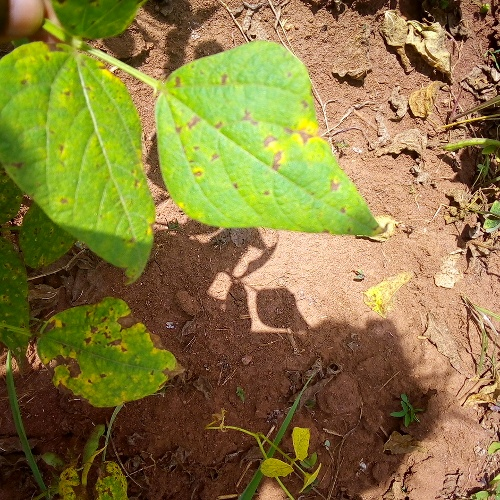

In [4]:
dataset["train"][0]["image"]

In [5]:
width, height = dataset["train"][0]["image"].size
print(f"Width: {width}, Height: {height}")

Width: 500, Height: 500


In [6]:
dataset["train"][0]["labels"]

0

In [7]:
labels = dataset["train"].features["labels"].names # label의 종류
print(labels) # 3가지 종류

['angular_leaf_spot', 'bean_rust', 'healthy']


In [8]:
# 1000개의 샘플만 사용해서 학습
num_samples = 1000
seed = 1004
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

Loading cached shuffled indices for dataset at /home/yunho/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791/cache-693c74a3707d3b2f.arrow


## Model

- Vision Transformer(ViT) base 모델 사용
- Alternative) Swin Transformer, ConvNeXT, RegNet 모델

In [9]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt) # extractor: pret_trained model feature 추출기
model = AutoModel.from_pretrained(model_ckpt) # model: feature 추출기를 통해 추출된 feature를 입력받아 output을 반환하는 모델

/home/yunho/anaconda3/envs/logo/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: 

In [10]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [11]:
model.config

ViTConfig {
  "_name_or_path": "nateraw/vit-base-beans",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "finetuning_task": "image-classification",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.29.2"
}

In [12]:
hidden_dim = model.config.hidden_size # 768

In [13]:
extractor.size["height"], extractor.size["width"] # 224, 224

(224, 224)

In [14]:
import torchvision.transforms as T

transformation_chain = T.Compose(
    [
        T.Resize(int((256 / 224) * extractor.size["height"])), # 256x256으로 resize
        T.CenterCrop(extractor.size["height"]), # 224x224로 center crop
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [15]:
import torch

# 이미지를 입력받아 feature를 반환하는 함수
def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad(): # gradient 계산 안함(training이 아니므로)
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu() # model에 이미지를 입력받아 feature를 반환
        return {"embeddings": embeddings} # feature 반환

    return pp

In [16]:
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device)) # model에 이미지를 입력받아 feature를 반환하는 함수
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=batch_size)

In [17]:
from tqdm.auto import tqdm

candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]
    
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry) # id와 label을 합쳐서 candidate_ids에 저장

100%|██████████| 1000/1000 [00:02<00:00, 369.40it/s]


In [18]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"]) # feature를 numpy array로 변환
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings) # numpy array를 torch tensor로 변환

In [19]:
def compute_scores(emb_one, emb_two):
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    # 이미지 전처리
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # 이미지에 대한 embedding 추출
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # 이미지와 가장 유사한 이미지를 찾기 위해 코사인 유사도 계산
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # 코사인 유사도가 높은 순으로 정렬
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

In [20]:
test_idx = np.random.choice(len(dataset["test"])) # test set에서 랜덤하게 샘플을 선택
test_sample = dataset["test"][test_idx]["image"] # 선택된 샘플의 이미지
test_label = dataset["test"][test_idx]["labels"] # 선택된 샘플의 라벨

sim_ids, sim_labels = fetch_similar(test_sample) # 선택된 샘플과 유사한 샘플을 찾아 id와 label을 반환
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 1
Top 5 candidate labels: [1, 1, 1, 1, 1]


In [21]:
label2id, id2label = dict(), dict() # label을 id로 변환하는 딕셔너리

for i, label in enumerate(labels):
    label2id[label] = i # label을 id로 변환
    id2label[i] = label # id를 label로 변환

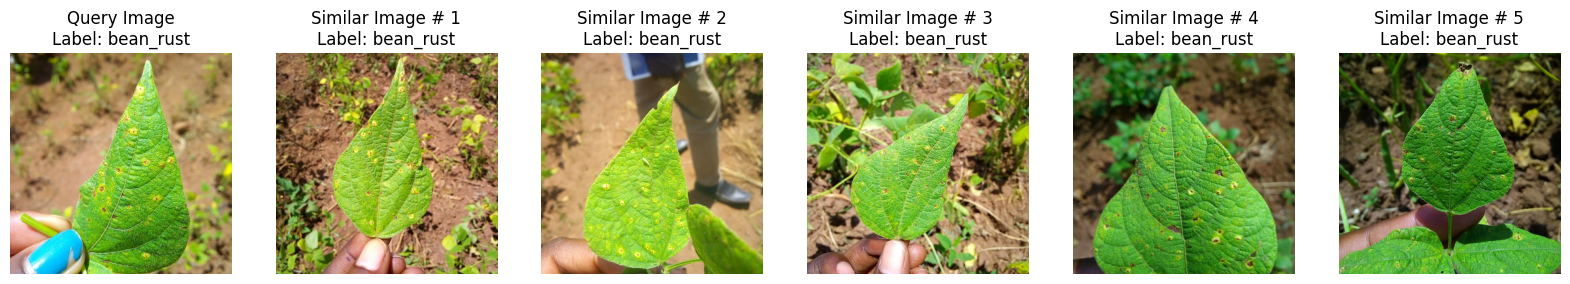

In [22]:
import matplotlib.pyplot as plt
import math


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(math.ceil(len(images) / columns) + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)